### 05/22/23 - This notebook is copied from home/shawnknabel/Documents/slacs_kinematics/jupyter_notebooks/kinematics_maps/plot_kinematics_contours/plot_kinematics_contours_V_VD_bspline_models_margin_gnog_050823.ipynb
#### See https://docs.google.com/spreadsheets/d/141wpCILejD7JhJdo5OuwJAY6xN7B-lNpK36Gbvr8o4k/edit#gid=1171125292&range=B478
#### I should have set the photometry up to convert to B-band instead of I-band for F435W
### 05/30/23 - Updating to do the other objects besides J0037... starting with J1621
### 05/31/23 - Updating correct photometry practices... See emails with Tommaso. 
https://mail.google.com/mail/u/0/?tab=rm&ogbl#inbox/QgrcJHsHpClsHsxLMLKBvnrXbjRmTmwFDTQ
### 06/01/23 - Cleaning up for ease of use.
# 06/05/23 - J1402

In [1]:
################################################################

# import general libraries and modules
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 14})
import pandas as pd
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "plotbin\..*" )
from os import path
import glob
#import Image from PIL
from PIL import Image
import pickle

# astronomy/scipy
from astropy.io import fits
from astropy.wcs import WCS
from scipy.ndimage import rotate
from scipy.ndimage import map_coordinates
from scipy.optimize import least_squares as lsq
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
#from astropy.cosmology import Planck15 as cosmo  # Originally I did Planck 2018, but it seems this one isn't in the version of astropy we have on here and I'm not 
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

# mge fit
import mgefit
from mgefit.find_galaxy import find_galaxy
from mgefit.mge_fit_1d import mge_fit_1d
from mgefit.sectors_photometry import sectors_photometry
from mgefit.mge_fit_sectors import mge_fit_sectors
from mgefit.mge_print_contours import mge_print_contours
from mgefit.mge_fit_sectors_regularized import mge_fit_sectors_regularized


# jam
from jampy.jam_axi_proj import jam_axi_proj
from jampy.jam_axi_proj import rotate_points
from jampy.jam_axi_proj import bilinear_interpolate
from jampy.mge_half_light_isophote import mge_half_light_isophote
from plotbin.plot_velfield import plot_velfield
from plotbin.sauron_colormap import register_sauron_colormap
register_sauron_colormap()
from pafit.fit_kinematic_pa import fit_kinematic_pa

# my functions
import sys
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages")
from slacs_mge_jampy import crop_center_image
from slacs_mge_jampy import import_center_crop
from slacs_mge_jampy import try_fractions_for_find_galaxy
from slacs_mge_jampy import convert_mge_model_outputs
from slacs_mge_jampy import plot_contours_321
from slacs_mge_jampy import plot_contours_531
from slacs_mge_jampy import load_2d_kinematics
from slacs_mge_jampy import bin_velocity_maps
from slacs_mge_jampy import rotate_bins
from slacs_mge_jampy import osipkov_merritt_model
from slacs_mge_jampy import find_half_light
from slacs_mge_jampy import calculate_minlevel
from slacs_mge_jampy import fit_kcwi_sigma_psf
from slacs_mge_jampy import optimize_sigma_psf_fit
from slacs_mge_jampy import estimate_hst_psf
from slacs_mge_jampy import plot_kinematics_mge_contours
from slacs_mge_jampy import get_bin_centers
from slacs_mge_jampy import jampy_details

################################################################
# some needed information
kcwi_scale = 0.1457  # arcsec/pixel
hst_scale = 0.050 # ACS/WFC


In [2]:
# specify object directory and name

#################################################
# date and number of initial kinematics run e.g. 2023-02-28_2
date_of_kin = '2023-02-28_2'

###################################################################################################################################

#------------------------------------------------------------------------------
# Directories and files

# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
hst_dir = '/data/raw_data/HST_SLACS_ACS/kcwi_kinematics_lenses/'
tables_dir = f'{data_dir}tables/'
mosaics_dir = f'{data_dir}mosaics/'
kinematics_full_dir = f'{data_dir}kinematics/'
kinematics_dir =f'{kinematics_full_dir}{date_of_kin}/'
print(f'Outputs will be in {kinematics_dir}')
print()

# target SN for voronoi binning
vorbin_SN_targets = np.array([10, 15, 20])

#################################################
# objects
obj_names = ['SDSSJ0029-0055',
             'SDSSJ0037-0942',
             'SDSSJ0330-0020',
             'SDSSJ1112+0826',
             'SDSSJ1204+0358',
             'SDSSJ1250+0523',
             'SDSSJ1306+0600',
             'SDSSJ1402+6321',
             'SDSSJ1531-0105',
             'SDSSJ1538+5817',
             'SDSSJ1621+3931',
             'SDSSJ1627-0053',
             'SDSSJ1630+4520',
             'SDSSJ2303+1422'
            ]

#################################################


Outputs will be in /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/kinematics/2023-02-28_2/



In [3]:
# class to collect and save all the attributes I need for jampy
class jampy_details:
    
    def __init__(details, surf_density, mge_sigma, q, kcwi_sigmapst, Vrms_bin, dVrms_bin, V_bin, dV_bin, xbin_phot, ybin_phot, reff):
        details.surf_density=surf_density 
        details.mge_sigma=mge_sigma
        details.q=q 
        details.kcwi_sigmapst=kcwi_sigmapst 
        details.Vrms_bin=Vrms_bin 
        details.dVrms_bind=dVrms_bin
        details.V_bin=V_bin 
        details.dV_bin=dV_bin 
        details.xbin_phot=xbin_phot 
        details.ybin_phot=ybin_phot
        details.reff=reff
        
def get_bins (file_dir, obj_name):
    
    scale=0.1457
    
    #######################################
    ## import voronoi binning data
    voronoi_binning_data = fits.getdata(file_dir +'voronoi_binning_' + obj_name + '_data.fits')
    vorbin_pixels = np.genfromtxt(f'{file_dir}voronoi_2d_binning_{obj_name}_output.txt',
                     delimiter='')
    # sort the voronoi bin pixel data by bin
    vorbin_pixels = vorbin_pixels[vorbin_pixels[:,2].argsort()]
    
    ########################################
    # find bin centers
    xbin, ybin = get_bin_centers (vorbin_pixels, len(voronoi_binning_data))
    
     #######################################
    # Changes - 11/30/22
    #######################################

    # convert to arcsec # kcwi!
    xbin_arcsec = xbin * scale
    ybin_arcsec = ybin * scale

    return xbin_arcsec, ybin_arcsec

In [4]:
obj_names[7]

'SDSSJ1402+6321'

# Load images

In [5]:
obj_names_index=7
obj_name = obj_names[obj_names_index]

print('#####################################################################################################################')
print('#####################################################################################################################')
print()
print(f'Beginning final kinematics visualization and plotting for object {obj_name}.')
print()

obj_abbr = obj_name[4:9] # e.g. J0029

    #------------------------------------------------------------------------------
# object-specific directories

mos_dir = f'{mosaics_dir}{obj_name}/' 
kin_dir = f'{kinematics_dir}{obj_name}/'

print('################################################')
print('Getting KCWI datacube')

kcwi_img, kcwi_5arc_img, kcwi_3arc_img, kcwi_header, \
    kcwi_central_pix_x, kcwi_central_pix_y, kcwi_pa = import_center_crop(data_dir, mos_dir, obj_name, obj_names_index, obj_abbr, 
                                                                          data_source='kcwi_datacube', plot=False)


hst_full_img, hst_5arc_img, hst_3arc_img, bspl_full_img, bspl_5arc_img, bspl_3arc_img, hst_header, \
    central_pix_x, central_pix_y, exp_time, bspl_PA = import_center_crop(data_dir, hst_dir, obj_name, obj_names_index, obj_abbr, 
                                                      data_source='HST', plot=False)

#####################################################################################################################
#####################################################################################################################

Beginning final kinematics visualization and plotting for object SDSSJ1402+6321.

################################################
Getting KCWI datacube
Rotate image by  -20.0


In [6]:
hst_header['filter2']

'F435W'

In [15]:
hst_header['EXPTIME']

420.0

In [20]:
hst_header['TOT_TIME']

420.0

In [26]:
hst_header['DATE-OBS']

'2004-08-04'

In [ ]:
#Results for 2004-08-04
#Detector	Filter	PHOTLAM [Å]	PHOTFLAM [erg cm⁻² Å⁻¹ e⁻¹]	STmag	VEGAmag	ABmag
#WFC	F435W	4329.2	3.1099e-19	25.168	25.793	25.678

# Bring in pickle for light profile, auxiliary data

In [11]:
file_m = glob.glob(f'{mos_dir}{obj_name}_mge_fit_sectors_regularized_model.pkl')
if file_m:
    print('mge model exists, loading...')
    with open(file_m[0], 'rb') as file:
        m = pickle.load(file)

    print('################################################')
    print('Regularized MGE fit')
    
# get the model surface brightness profiles
# convert sigma from pixels to arcsec
sigma_pix = m.sol[1]
sigma = sigma_pix * hst_scale
# q 
q = m.sol[2]
# surface brightness
total_counts = m.sol[0]    

# bring in the paper table for 
paper_table = pd.read_csv(f'{tables_dir}paper_table_051223.csv')

# start with J0037
#obj_name = 'SDSSJ0037-0942' # e.g. SDSSJ0037-0942
#obj_abbr = obj_name[4:9] # e.g. J0029
zlens = paper_table[paper_table['obj_name']==obj_name]['zlens'].to_numpy()[0] #zs[1]
ang_distance = cosmo.angular_diameter_distance(zlens).value
lum_distance = cosmo.luminosity_distance(zlens).value

mos_dir = f'{mosaics_dir}{obj_name}/' # directory with all files of obj_name
kin_dir = f'{kinematics_dir}{obj_name}/'
#jam_dir = f'{jam_output_dir}{obj_name}/'
# create a directory for JAM outputs
#Path(jam_dir).mkdir(parents=True, exist_ok=True)


mge model exists, loading...
################################################
Regularized MGE fit


# Load tables from SLACS IX

In [12]:
tab3 = pd.read_csv(f'{tables_dir}slacs_ix_table3.csv')
tab4 = pd.read_table(f'{tables_dir}slacs_ix_table4.txt')

In [13]:
tab4.columns

Index(['Name', 'r_Ein (kpc)', 'log[M_Ein/M_sun]', 'f^Chab_*,Ein',
       'f^Salp_*,Ein', '$\frac{f_{\rm *,Ein}}{f_{\rm *,eff}}$',
       'log[M^Chab_*/M_sun]', 'log[M^Salp_*/M_sun]', 'M_B', 'M_V', 'M_B,0',
       'M_V,0', 'Unnamed: 12'],
      dtype='object')

In [29]:
# calculate restrfame correction from DM and redshift
r = lum_distance * 10**6 # distance in pc
DM = 5 * np.log10(r/10)
# slacs ix values
B9 = float(tab4[tab4['Name']==obj_name]['M_B'].values[0][:6]) #-22.37
b9 = float(tab3[tab3['Name']==obj_name]['m_B'].values[0]) #18.57 # B band app mag
v9 = float(tab3[tab3['Name']==obj_name]['m_V'].values[0]) # 16.9 # V band app mag
# alpha and beta are functions of redshift (from https://iopscience.iop.org/article/10.1086/444585/fulltext/)
a0 = 0.824411
a1 = -3.29360
a2 = 3.40645
alpha = a0 + a1 * zlens /  + a2 * zlens**2   # alpha coeffi
b0 = -0.00169895
b1 = 1.22223
b2 = -8.36258
b3 = 18.9313
beta = b0 + b1 * zlens + b2 * zlens**2 + b3 * zlens**3 # coeff 
# final calculation
restframe_correction = (1 - alpha) * (v9 - b9) + beta - DM

# photometry corrections and zeropoint
#Results for 2004-08-04 - J1402
#Detector	Filter	PHOTLAM [Å]	PHOTFLAM [erg cm⁻² Å⁻¹ e⁻¹]	STmag	VEGAmag	ABmag
#WFC	F435W	4329.2	3.1099e-19	25.168	25.793	25.678
zeropoint = 25.678 #
inf_ap_correction = 0.1
extinctions = pd.read_csv(f'{data_dir}tables/slacs_extinctions.csv')
extinction = extinctions.loc[extinctions.obj_name == obj_name, 'A_B'].values[0]

# counts of Gaussians to apparent magnitude
B_app_mag = - 2.5 * np.log10(total_counts/exp_time) + zeropoint + inf_ap_correction - extinction

# correct to restframe
B_abs_mag = B_app_mag + restframe_correction

# convert to surface magnitudes
B_surf_mag = B_abs_mag + 2.5 * np.log10(2*np.pi*q*sigma_pix**2*hst_scale**2)

# convert to surface brightness in L_sol_B / pc^2
#M_sol_I = 4.08
M_sol_B = 5.45
B_surf_br_arcsec = 10**( 0.4 * (M_sol_B - B_surf_mag)) # L_sol_B / arcsec^2
B_surf_br_pc = B_surf_br_arcsec * (206265/(ang_distance*10**6))**2

# calculate total magnitude for fudge factor to scale to slacs ix value
total_appmag_B = zeropoint + inf_ap_correction + 2.5 * np.log10(exp_time) \
                            - 2.5 * np.log10(np.sum(total_counts)) - extinction
total_magnitude_B = total_appmag_B + restframe_correction 
log_fudge_factor = total_magnitude_B - B9
fudged_surface_brightness = B_surf_br_pc * 10**(0.4 * log_fudge_factor)

fudged_surface_brightness



array([12068.91113539,  3178.12522098,   732.39279898,   462.58034195,
         113.11137529])

In [30]:
log_fudge_factor

1.3704098866350307

# Replace the surface brightness in "details_for_jampy.pkl" for all SN schemes

In [31]:
for SN in vorbin_SN_targets:
    target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
    #target_jam_dir = f'{jam_dir}target_sn_{SN}/'
    # create a directory for JAM outputs
    #Path(target_jam_dir).mkdir(parents=True, exist_ok=True)

    # take the surface density, etc from mge saved parameters
    with open(f'{target_kin_dir}{obj_name}_{SN}_details_for_jampy.pkl', 'rb') as f:
        tommy_pickles = pickle.load(f)


    tommy_pickles.surf_density = fudged_surface_brightness
    
    # dump the pickle back in
    with open(f'{target_kin_dir}{obj_name}_{SN}_details_for_jampy.pkl', 'wb') as f:
        pickle.dump(tommy_pickles, f)

# Look at the orientation

In [32]:
SN = '15'
target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'

# take the surface density, etc from mge saved parameters
with open(f'{target_kin_dir}{obj_name}_{SN}_details_for_jampy.pkl', 'rb') as f:
    tommy_pickles = pickle.load(f)


surf = tommy_pickles.surf_density
sigma = tommy_pickles.mge_sigma
qObs = tommy_pickles.q
kcwi_sigmapsf = tommy_pickles.kcwi_sigmapsf
Vrms_bin = tommy_pickles.Vrms_bin
dVrms_bin = tommy_pickles.dVrms_bind # mistake in name
V_bin = tommy_pickles.V_bin
dV_bin = tommy_pickles.dV_bin
xbin_phot = tommy_pickles.xbin_phot
ybin_phot = tommy_pickles.ybin_phot
reff = tommy_pickles.reff


axis_info = np.genfromtxt(f'{target_kin_dir}{obj_name}phot_kin_axis_info.txt', delimiter=',')
pa_phot = axis_info[2]


xbin_arcsec, ybin_arcsec = get_bins (f'{kin_dir}target_sn_{SN}/', obj_name)


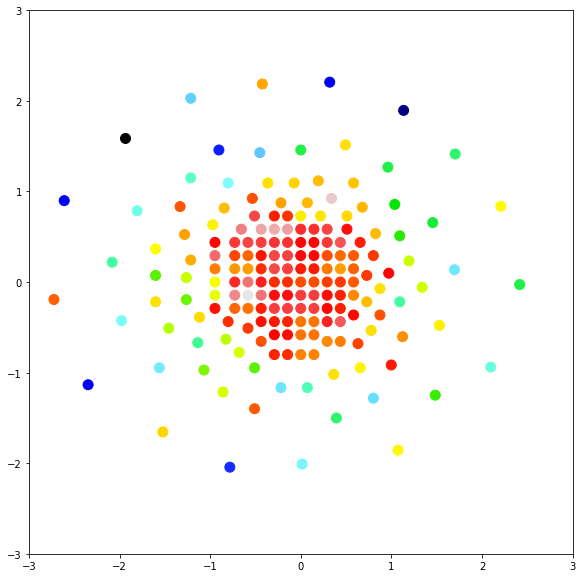

In [35]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(xbin_arcsec, ybin_arcsec, s=100, c=Vrms_bin, cmap='sauron')
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_aspect('equal')

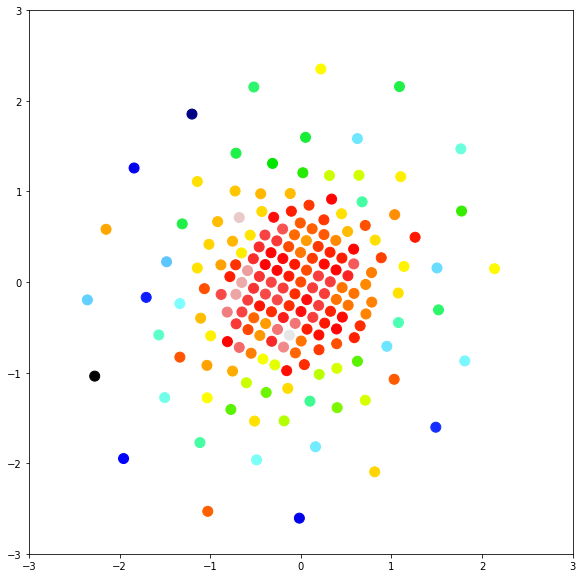

In [36]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(xbin_phot, ybin_phot, s=100, c=Vrms_bin, cmap='sauron')
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_aspect('equal')

# See if it rotates properly with KCWI PA and PA_phot

In [37]:
xbin_phot_rot, ybin_phot_rot = rotate_points(xbin_arcsec, ybin_arcsec, kcwi_pa-90-pa_phot)

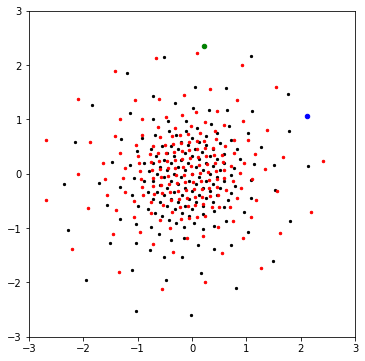

In [38]:
fig, axs = plt.subplots(1, figsize=(8,6))
axs.scatter(xbin_phot, ybin_phot,s=5,c='k',)
axs.scatter(xbin_phot_rot, ybin_phot_rot, s=6, c='r')
axs.scatter(xbin_phot[-1], ybin_phot[-1],s=20,c='g',)
axs.scatter(xbin_phot_rot[-1], ybin_phot_rot[-1], s=20, c='b')
axs.set_xlim(-3,3)
axs.set_ylim(-3,3)
axs.set_aspect('equal')

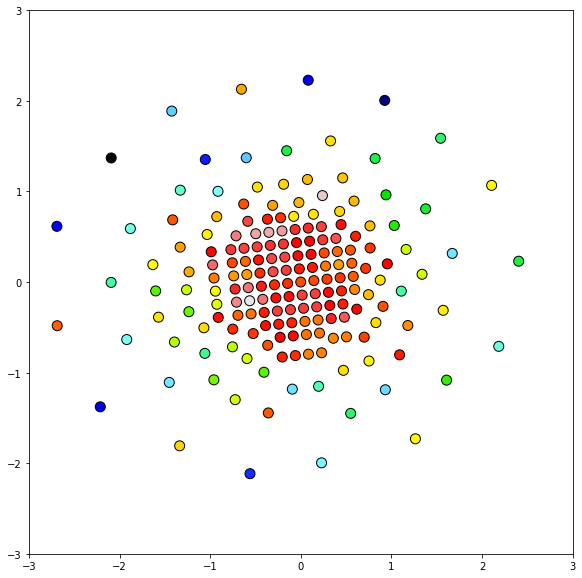

In [40]:

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(xbin_phot_rot, ybin_phot_rot, s=100, edgecolor='k', c=Vrms_bin, cmap='sauron')
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_aspect('equal')

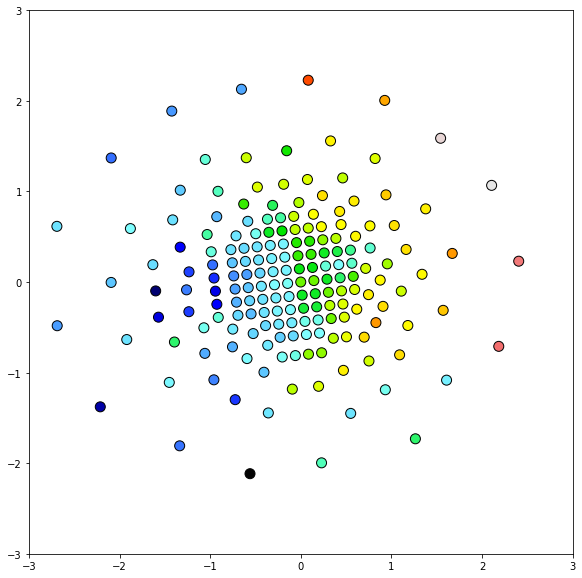

In [42]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(xbin_phot_rot, ybin_phot_rot, s=100, edgecolor='k', c=V_bin, cmap='sauron')
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_aspect('equal')

# Check the JAM model

####################################################
####################################################
Rotated by pa_phot
jam_axi_proj_sph_z (analytic_los=False) elapsed time sec: 3.40
inc=75.0; beta[1]=0.20; kappa=0.862; M/L=1.00; BH=0.0; chi2/DOF=2.61
Total mass MGE (MSun): 1.191e+11


/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)


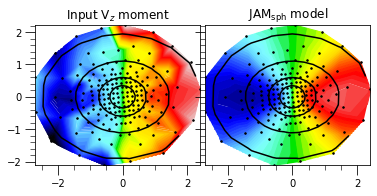

jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 3.39
inc=75.0; beta[1]=0.20; kappa=1.00; M/L=5.77; BH=0.0; chi2/DOF=0.00398
Total mass MGE (MSun): 6.869e+11


/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/shawnknabel/.local/lib/python3.7/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)


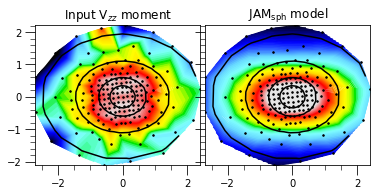

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [43]:
pixsize=kcwi_scale
beta=np.ones_like(surf)*0.2
sigmapsf=kcwi_sigmapsf,
goodbins=None
inc=75
mbh=0
distance=cosmo.angular_diameter_distance(zlens).value


print('####################################################')
print('####################################################')
print(f'Rotated by pa_phot')

moment = 'z'
data = V_bin
errors = dV_bin

# The model is by design similar but not identical to the adopted kinematics!
jam_axi_proj(surf, sigma, qObs, surf, sigma, qObs,
                 inc, mbh, distance, xbin_phot_rot, ybin_phot_rot, plot=True, data=data, errors=errors,
                 sigmapsf=sigmapsf, #normpsf=normpsf,
                 #flux_obs=flux_obs,
                 beta=beta, pixsize=pixsize,
                 moment=moment, goodbins=goodbins, 
                 align='sph', ml=None, nodots=False)
plt.pause(3)
plt.figure(2)

moment = 'zz'
data = Vrms_bin
errors = dVrms_bin

# The model is by design similar but not identical to the adopted kinematics!
jam_axi_proj(surf, sigma, qObs, surf, sigma, qObs,
                 inc, mbh, distance, xbin_phot_rot, ybin_phot_rot, plot=True, data=data, errors=errors,
                 sigmapsf=sigmapsf, #normpsf=normpsf,
                 #flux_obs=flux_obs,
                 beta=beta, pixsize=pixsize,
                 moment=moment, goodbins=goodbins, 
                 align='sph', ml=None, nodots=False)
plt.pause(3)
plt.figure(2)


# Now rotate and update SN 10, 15, and 20

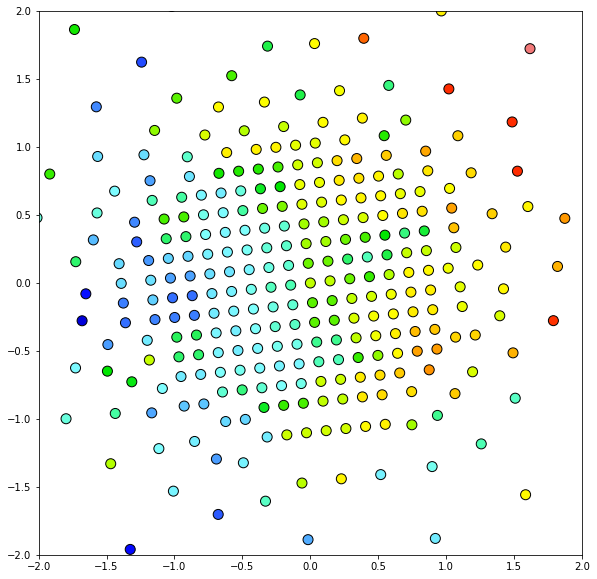

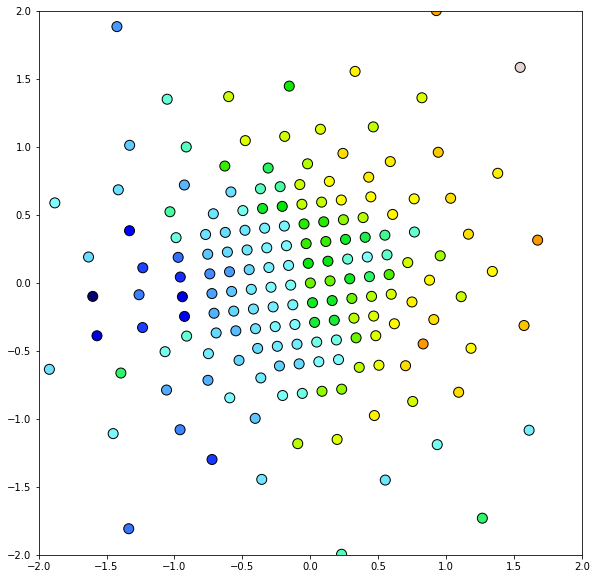

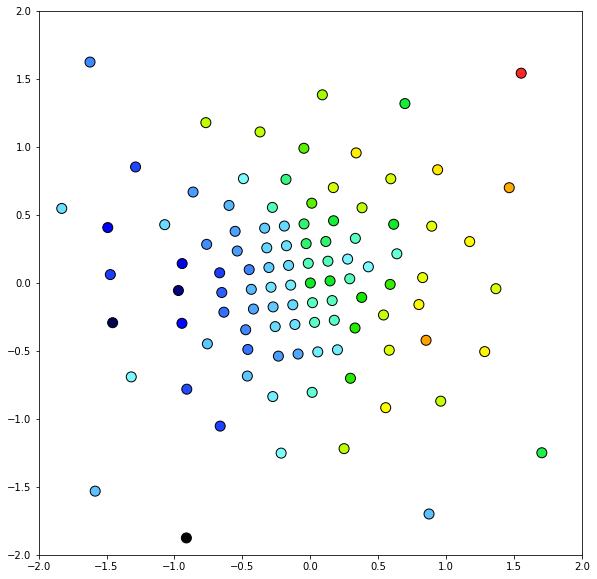

In [44]:
for SN in vorbin_SN_targets:
    target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
    #target_jam_dir = f'{jam_dir}target_sn_{SN}/'
    # create a directory for JAM outputs
    #Path(target_jam_dir).mkdir(parents=True, exist_ok=True)

    # take the surface density, etc from mge saved parameters
    with open(f'{target_kin_dir}{obj_name}_{SN}_details_for_jampy.pkl', 'rb') as f:
        tommy_pickles = pickle.load(f)

    surf = tommy_pickles.surf_density
    sigma = tommy_pickles.mge_sigma
    qObs = tommy_pickles.q
    kcwi_sigmapsf = tommy_pickles.kcwi_sigmapsf
    Vrms_bin = tommy_pickles.Vrms_bin
    dVrms_bin = tommy_pickles.dVrms_bind # mistake in name
    V_bin = tommy_pickles.V_bin
    dV_bin = tommy_pickles.dV_bin
    xbin_phot = tommy_pickles.xbin_phot
    ybin_phot = tommy_pickles.ybin_phot
    reff = tommy_pickles.reff


    axis_info = np.genfromtxt(f'{target_kin_dir}{obj_name}phot_kin_axis_info.txt', delimiter=',')
    pa_phot = axis_info[2]


    xbin_arcsec, ybin_arcsec = get_bins (f'{kin_dir}target_sn_{SN}/', obj_name)

    xbin_phot_rot, ybin_phot_rot = rotate_points(xbin_arcsec, ybin_arcsec, kcwi_pa-90-pa_phot)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(xbin_phot_rot, ybin_phot_rot, s=100, edgecolor='k', c=V_bin, cmap='sauron')
    ax.set_xlim(-3,3)
    ax.set_ylim(-3,3)
    ax.set_aspect('equal')
    
    # replace values for xbinphot and ybinphot
    tommy_pickles.xbin_phot = xbin_phot_rot
    tommy_pickles.ybin_phot = ybin_phot_rot
    
    # dump the pickle back in
    #with open(f'{target_kin_dir}{obj_name}_{SN}_details_for_jampy.pkl', 'wb') as f:
    #    pickle.dump(tommy_pickles, f)